## ライブラリのインポート

In [31]:
import numpy as np
# ワインの計測データ
from sklearn.datasets import load_wine
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# 予測結果の精度表示
from sklearn import metrics
# グラフ描画
from matplotlib import pyplot as plt
%matplotlib inline
import japanize_matplotlib
from pandas.plotting import scatter_matrix

In [7]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

# テスト用データの読み込み

In [38]:
class WineDataset(Dataset):
    def __init__(self, testsize=0.2):
        wine = load_wine()
        self.X = wine.data
        self.target = wine.target
        self.feature_names = wine.feature_names
        
        Y = np.zeros((len(wine.target), 1 + wine.target.max()), dtype=int)
        Y[np.arange(len(wine.target)), wine.target] = 1
        
        # 訓練データと検証データに分割する
        X_train,X_test,Y_train,Y_test=train_test_split(self.X, Y, test_size=testsize, random_state=1) 
        
        # テンソルに変換
        self.X_data = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.Y_data = torch.FloatTensor(Y_train)
        self.Y_test = torch.FloatTensor(Y_test)
        self.X_fulldata = torch.FloatTensor(self.X)
        self.Y_fulldata = torch.FloatTensor(Y)
        
        self.datalen = len(self.Y_data)
        self.in_size = self.X_data.shape[1]
        self.out_size = self.Y_data.shape[1]
        print('X_size=', self.in_size)
        print('Y_size=', self.out_size)
        print('record_cnt=', self.datalen)
        
    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]
    
    def __len__(self):
        return self.datalen

In [39]:
Batch_size = 15
dataset = WineDataset()
trainloader = DataLoader(dataset=dataset, batch_size = Batch_size, shuffle=True)

X_size= 13
Y_size= 3
record_cnt= 142


# ニューラルネットワークの定義

ニューラルネットワークのノード数や階層を定義する \
出力値を求める関数を定義する（ノード数によって変わる、求めたい値によっても変わる）

In [14]:
# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self, in_features, out_features, h1=128, h2=32):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_features , h1) 
        self.fc2 = nn.Linear(h1 , h2)          
        self.fc3 = nn.Linear(h2,  out_features) 
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
        x = F.sigmoid(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = F.sigmoid(self.fc2(x))              # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.fc3(x)                         # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        return F.log_softmax(x , dim=1)

# 学習する

In [15]:
# モデルの定義
model = Net(in_features = dataset.in_size, out_features = dataset.out_size)
# 損失の定義 (平均二乗誤差)
criterion = nn.MSELoss()

In [16]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.0001)

In [19]:
loss_list = []
loss_temp = 0

epochs=2000
logdisp=100

accuracy_list = []

correct_counter = 0
acccnt=len(dataset)*logdisp

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in trainloader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        
        y_pred = torch.max(output.data, axis=1)[1]
        t_true = torch.max(y_train.data, axis=1)[1]

        correct_temp = (t_true == y_pred).sum()
        correct_counter += correct_temp
        
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp=total_loss/acccnt
        print(f'Epoch\t{epoch+1}\t\tLoss\t{loss_tmp:.8f}\t\taccuracy:\t{(correct_counter*100)/acccnt:.3f}%')
        
        accuracy_list.append(correct_counter.item()*100/(acccnt))
        loss_list.append(loss_tmp)
        loss_temp=0
        total_loss=0
        correct_counter = 0
        

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch	100		Loss	0.00155898		accuracy:	87.000%
Epoch	200		Loss	0.00155273		accuracy:	92.000%
Epoch	300		Loss	0.00155038		accuracy:	93.000%
Epoch	400		Loss	0.00154909		accuracy:	94.000%
Epoch	500		Loss	0.00154647		accuracy:	95.000%
Epoch	600		Loss	0.00154603		accuracy:	95.000%
Epoch	700		Loss	0.00154549		accuracy:	95.000%
Epoch	800		Loss	0.00154531		accuracy:	96.000%
Epoch	900		Loss	0.00154491		accuracy:	96.000%
Epoch	1000		Loss	0.00154450		accuracy:	97.000%
Epoch	1100		Loss	0.00154430		accuracy:	98.000%
Epoch	1200		Loss	0.00154407		accuracy:	98.000%
Epoch	1300		Loss	0.00154408		accuracy:	98.000%
Epoch	1400		Loss	0.00154381		accuracy:	98.000%
Epoch	1500		Loss	0.00154351		accuracy:	98.000%
Epoch	1600		Loss	0.00154311		accuracy:	98.000%
Epoch	1700		Loss	0.00154301		accuracy:	98.000%
Epoch	1800		Loss	0.00154322		accuracy:	98.000%
Epoch	1900		Loss	0.00154274		accuracy:	98.000%
Epoch	2000		Loss	0.00154251		accuracy:	98.000%


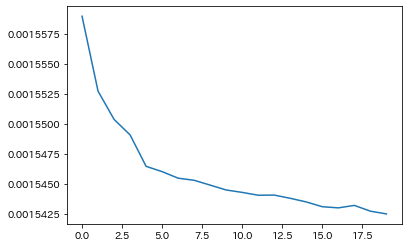

In [20]:
# ロスのプロット
plt.plot(loss_list)

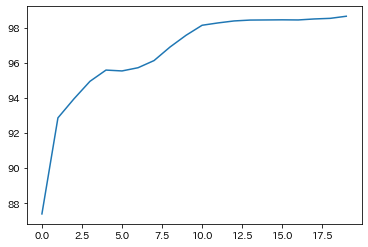

In [21]:
plt.plot(accuracy_list)

## 誤差の確認

In [22]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x_test ,y_test = Variable(dataset.X_test) ,Variable(dataset.Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = torch.max(model(x_test).data ,1)[1]
# 正解データは形を変えているので、元に戻す
y_true = np.argmax(y_test, axis=1)
# テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
accuracy = np.sum(y_true.numpy() == y_hat.numpy()) /len(y_test.data)

In [23]:
# 正解データ
y_true.numpy()

array([2, 1, 0, 1, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1], dtype=int64)

In [24]:
# 予測値
y_hat.numpy()

array([2, 1, 0, 1, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 1, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1], dtype=int64)

In [25]:
# 予測値の正解率
accuracy

0.9444444444444444

In [26]:
print(metrics.classification_report(y_true.numpy(),y_hat.numpy() ))  # 正解率など
print('-----')
print(metrics.confusion_matrix(y_true.numpy(), y_hat.numpy() ))     # 行:正解、列:予測

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.87      1.00      0.93        13
           2       1.00      0.89      0.94         9

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.94        36
weighted avg       0.95      0.94      0.95        36

-----
[[13  1  0]
 [ 0 13  0]
 [ 0  1  8]]


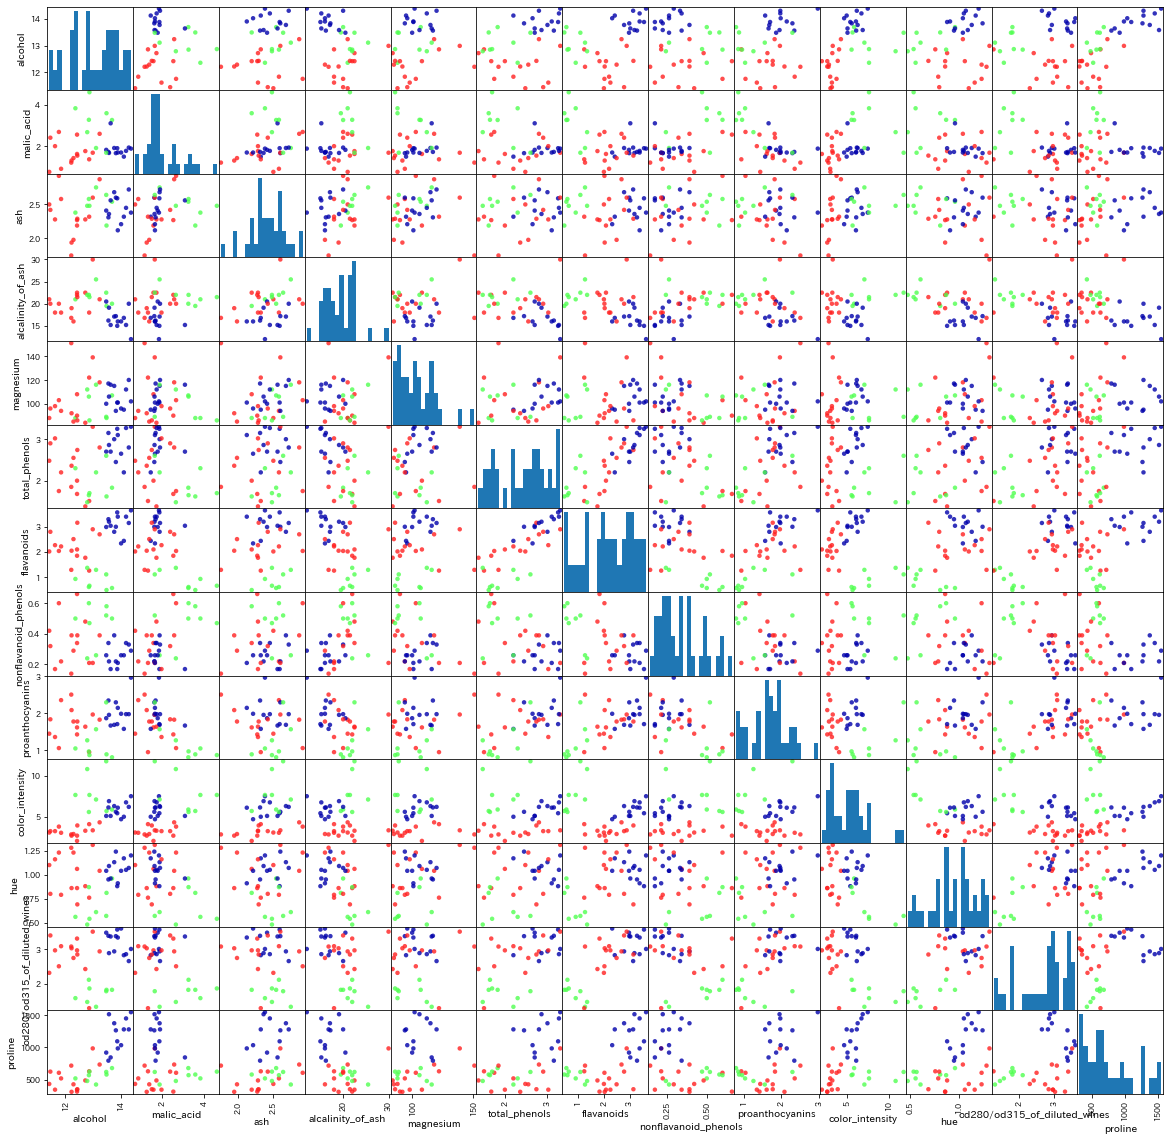

In [33]:
import mglearn
df_x_test=pd.DataFrame(dataset.X_test.numpy() ,columns=dataset.feature_names)
grr = scatter_matrix(df_x_test, c=y_hat.numpy() , figsize=(20, 20), marker='o', hist_kwds={'bins': 20}, s=20, alpha=.8, cmap=mglearn.cm3)
plt.show()

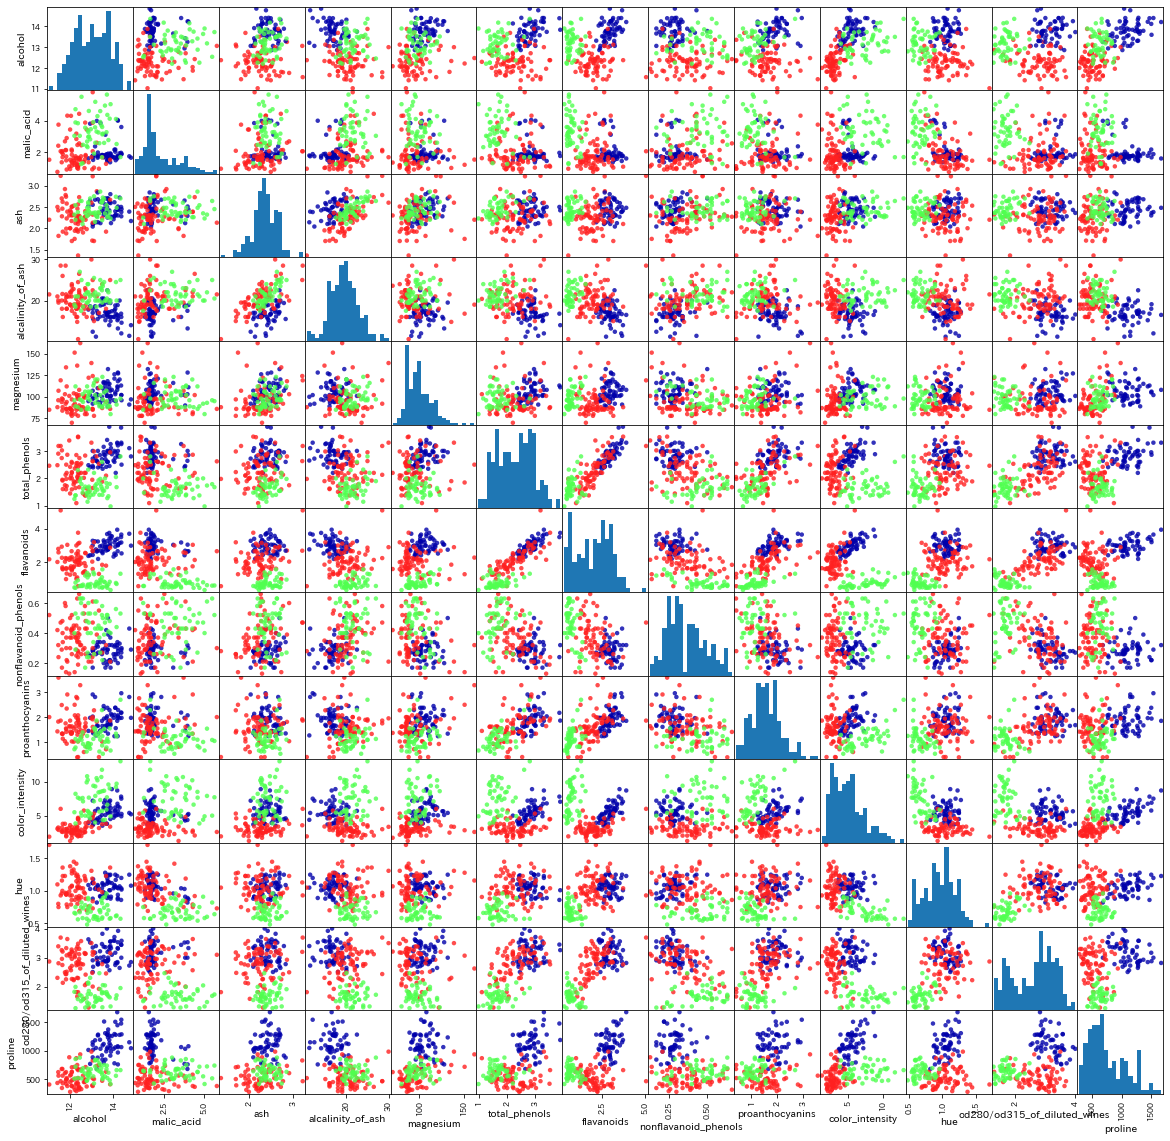

In [40]:
# 全データで予測
y_hat2 = torch.max(model(dataset.X_fulldata).data ,1)[1]
df_x_test=pd.DataFrame(dataset.X ,columns=dataset.feature_names)
grr = scatter_matrix(df_x_test, c=y_hat2.numpy(), figsize=(20, 20), marker='o', hist_kwds={'bins': 20}, s=20, alpha=.8, cmap=mglearn.cm3)
plt.show()

In [41]:
print(metrics.classification_report(dataset.target,y_hat2.numpy() ))  # 正解率など
print('-----')
print(metrics.confusion_matrix(dataset.target, y_hat2.numpy() ))     # 行:正解、列:予測

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        59
           1       0.96      1.00      0.98        71
           2       1.00      0.98      0.99        48

    accuracy                           0.98       178
   macro avg       0.99      0.98      0.98       178
weighted avg       0.98      0.98      0.98       178

-----
[[57  2  0]
 [ 0 71  0]
 [ 0  1 47]]


## 予測する

In [48]:
def print_predict(_x , _y):
    print('入力データ',_x)
    y_predict = model(_x).data
    print('予測値(確率)',y_predict)
    print('予測値',torch.max(y_predict ,1)[1])
    print('正解',torch.max(_y,1)[1])

In [49]:
# 全データの１件目　　：　Class_0
print_predict(dataset.X_fulldata[0:1] , dataset.Y_fulldata[0:1])

入力データ tensor([[1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
         3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
         1.0650e+03]])
予測値(確率) tensor([[-0.8188, -1.2743, -1.2751]])
予測値 tensor([0])
正解 tensor([0])


In [50]:
# 全データの５９件目：　Class_1
print_predict(dataset.X_fulldata[59:60] , dataset.Y_fulldata[59:60])

入力データ tensor([[1.2370e+01, 9.4000e-01, 1.3600e+00, 1.0600e+01, 8.8000e+01, 1.9800e+00,
         5.7000e-01, 2.8000e-01, 4.2000e-01, 1.9500e+00, 1.0500e+00, 1.8200e+00,
         5.2000e+02]])
予測値(確率) tensor([[-1.2061, -0.9286, -1.1857]])
予測値 tensor([1])
正解 tensor([1])


In [51]:
# 全データの１３０件目：　Class_2
print_predict(dataset.X_fulldata[130:131] , dataset.Y_fulldata[130:131])

入力データ tensor([[1.2860e+01, 1.3500e+00, 2.3200e+00, 1.8000e+01, 1.2200e+02, 1.5100e+00,
         1.2500e+00, 2.1000e-01, 9.4000e-01, 4.1000e+00, 7.6000e-01, 1.2900e+00,
         6.3000e+02]])
予測値(確率) tensor([[-1.2588, -0.9987, -1.0566]])
予測値 tensor([1])
正解 tensor([2])
